In [112]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

import ipywidgets as widgets
from IPython.display import display
import pickle

In [113]:
theta_true = torch.Tensor([0])
prior = torch.distributions.Normal(0, 5)
N=100

# True Posteriors

## Observing 2 random variable $ z_1, z_2 \sim \mathcal{N}(\theta, 1) $

In [114]:

#Say we observe z1, z2
zi = torch.distributions.Normal(theta_true, 1).sample((N,)).squeeze().tolist()
z1, z2 = zi[0], zi[1]

In [137]:

def posterior_z(theta, z1=z1, z2=z2):
    """Posterior if we observe z1, z2"""
    def improper_posterior_z(theta, z1=z1, z2=z2):
        likelihood_part = -(np.square(theta-z1) + np.square(theta-z2))/2
        prior_part = np.square(theta)/50
        res = np.exp(likelihood_part)*np.exp(prior_part)
        return res
    Z_z1_z2, eps = integrate.quad(improper_posterior_z,-15,15) #Integrale of p_impropre(θ|z1,z2)
    return improper_posterior_z(theta, z1, z2)/Z_z1_z2


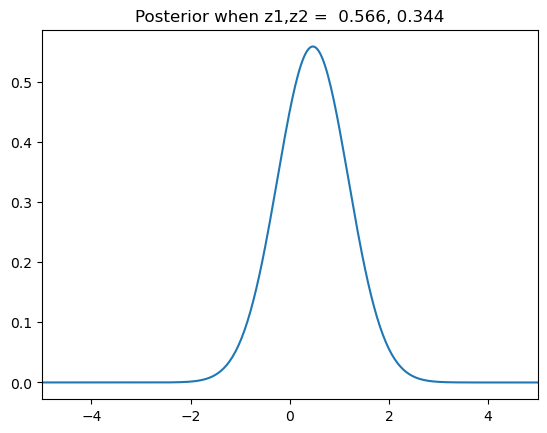

In [116]:
theta_grid = np.linspace(-15,15,1000)
eval_post = [posterior_z(theta, z1, z2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post)
plt.xlim(left=-5,right=5)
plt.title(f"Posterior when z1,z2 =  {z1:.3f}, {z2:.3f}")
plt.show()

In [203]:
mu = (z1 +z2) /(2+1/25)
var = (2+1/25)**(-1)
mu

0.44605736346805797

In [260]:
np.random.normal(1)

-0.07807218827770712

In [261]:
def uniform_proposal(x, delta=2.0):
    return np.random.normal(x)#(x - delta, x + delta)

def metropolis_sampler(p, nsamples, proposal=uniform_proposal):
    x = 1 # start somewhere

    for i in tqdm(range(nsamples)):
        trial = proposal(x) # random neighbour from the proposal distribution
        acceptance = p(trial)/p(x)

        # accept the move conditionally
        if np.random.uniform() < acceptance:
            x = trial

        yield x
true_samples = list(metropolis_sampler(posterior_z, 100_000))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [239]:
np.mean(true_samples[:90_000])

25.642261953882894

## Say we observed the mean of two random variables, $x= \frac{1}{2}(z_1 + z_2) $

In [6]:
x = (z1 + z2)/2

In [7]:
def posterior_x(theta, x):
    """Posterior when observing x=mean(z1, z2)"""
    def improper_posterior_x(theta, x=x):
        likelihood_part = -np.square(theta - x)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x, eps = integrate.quad(improper_posterior_x, -15, 15)
    return improper_posterior_x(theta,x)/z_x

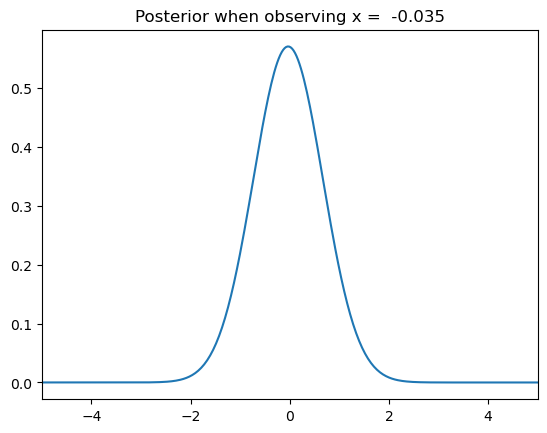

In [8]:
eval_post_x = [posterior_x(theta, x) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_x)
plt.xlim(left=-5,right=5)
plt.title(f"Posterior when observing x =  {x:.3f}")
plt.show()

## Say we observed the mean of N random variables

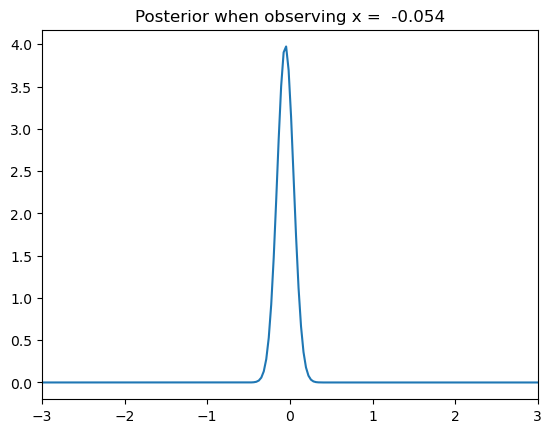

In [9]:
x = np.mean(zi)


def posterior_x_N(theta,x):
    """Posterior when observing x= mean(z1, z2... ,zn)"""
    def impropoer_posterior_x_N(theta, x=x):
        likelihood_part = -N*np.square(theta -x)/2
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_x_n, eps = integrate.quad(impropoer_posterior_x_N,-15, 15)
    return impropoer_posterior_x_N(theta,x)/z_x_n



eval_post_x_n = [posterior_x_N(theta, x) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_x_n)
plt.title(f"Posterior when observing x =  {x:.3f}")
plt.xlim(left=-3,right=3)
plt.show()

## Suppose we observed the mean and the variance of N random variables

In [10]:
x1 = np.mean(zi)
x2 = np.var(zi)
np.abs(x1 - theta_true)

tensor([0.0542])

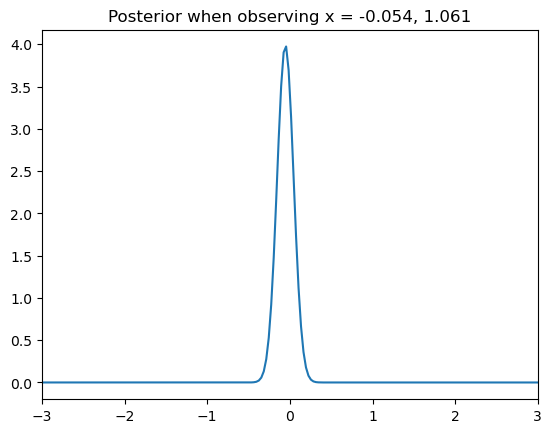

In [11]:
def posterior_summaries(theta, x1, x2):
    """Posterior when observing x= mean(z1...zn), var(z1...zn)"""
    def impropoer_posterior_summaries(theta,x1=x1,x2=x2):
        likelihood_x1_part = -N*np.square(theta - x1)/2
        likelihood_x2_part = -N*np.square(1 - x2)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_x1_part)*np.exp(likelihood_x2_part)*np.exp(prior_part)+1e-9
    z_summaries, eps = integrate.quad(impropoer_posterior_summaries, -25, 25)
    return impropoer_posterior_summaries(theta,x1,x2)/z_summaries

eval_post_summaries = [posterior_summaries(theta, x1, x2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_summaries)
plt.title(f"Posterior when observing x = {x1:.3f}, {x2:.3f}")
plt.xlim(left=-3,right=3)
plt.show()

## Suppose we observed the variance of N random variables

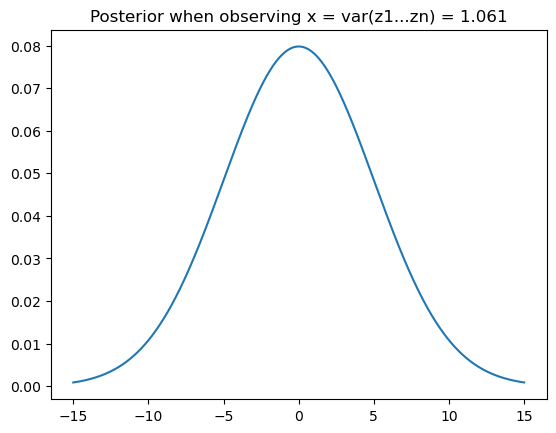

In [20]:
def posterior_var(theta, x):
    """Posterior when observing x= var(z1...zn)"""
    def improper_posterior_var(theta,x=x):
        likelihood_part = -N*np.square(x-1)
        prior_part = -np.square(theta)/50
        return np.exp(likelihood_part)*np.exp(prior_part)
    z_summaries, eps = integrate.quad(improper_posterior_var, -25, 25)
    return improper_posterior_var(theta,x)/z_summaries

eval_post_summaries = [posterior_var(theta, x2) for theta in theta_grid]
fig = plt.figure()
plt.plot(theta_grid, eval_post_summaries)
plt.title(f"Posterior when observing x = var(z1...zn) = {x2:.3f}")
#plt.xlim(left=-3,right=3)
plt.show()

## Comparaison

c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\matplotlib\cbook\__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


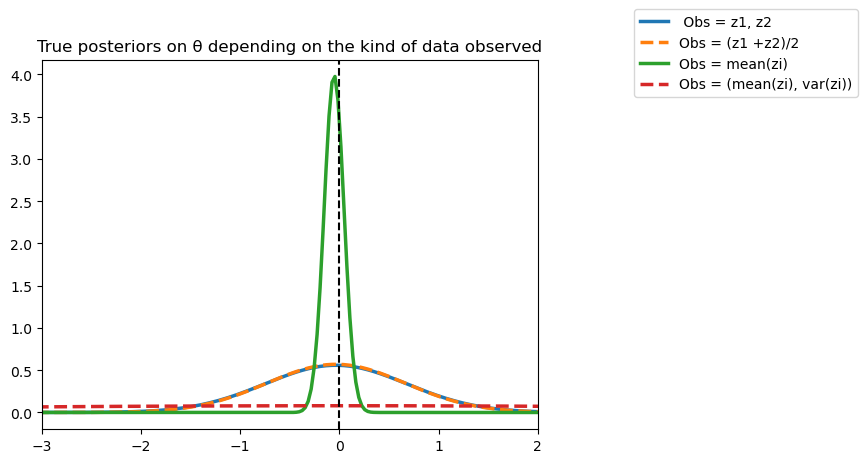

In [21]:
fig = plt.figure()
plt.xlim(left=-3, right=2)
plt.plot(theta_grid, eval_post, label=" Obs = z1, z2", linewidth=2.5)
plt.plot(theta_grid, eval_post_x, label="Obs = (z1 +z2)/2", linestyle='dashed', linewidth=2.5)
plt.plot(theta_grid, eval_post_x_n, label="Obs = mean(zi)", linewidth=2.5)
plt.plot(theta_grid, eval_post_summaries, label="Obs = (mean(zi), var(zi))", linestyle="dashed", linewidth=2.5)
plt.axvline(x=theta_true, ls='--', c='k')
fig.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title("True posteriors on θ depending on the kind of data observed")
plt.show()


As expected the last 2 methods yield similar results

In [95]:
def get_true_post(summaries, x_star):
    if "two_z" == summaries:
        #We observe z1, z2
        post = [posterior_z(theta_i, x_star[0], x_star[1]) for theta_i in theta_grid]
    elif "mean_two_z"== summaries:
        #We observed x = mean(z1, z2)
        post = [posterior_x(theta_i,x_star) for theta_i in theta_grid]
        
    elif "var"==summaries:
        #We observe x=var(z1...zn)
        post = [posterior_var(theta_i, x_star) for theta_i in theta_grid]
    elif "var" in summaries and "mean" in summaries:
        #We observe x = (x1, x2) = (mean, var)
        post = [posterior_summaries(theta_i, x_star[0], x_star[1]) for theta_i in theta_grid]


    elif "mean"==summaries:
        #We observe x = mean(z1, ... z100)
        post = [posterior_x_N(theta_i, x_star) for theta_i in theta_grid]
    return post

In [ ]:
 ["two_z", "mean_two_z", "mean", "mean_and_var"]

# Now let us compare these true posteriors to the estimations using SBI

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 17 epochs.

C:\Users\mmmat\AppData\Local\Temp\ipykernel_15696\3995100479.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


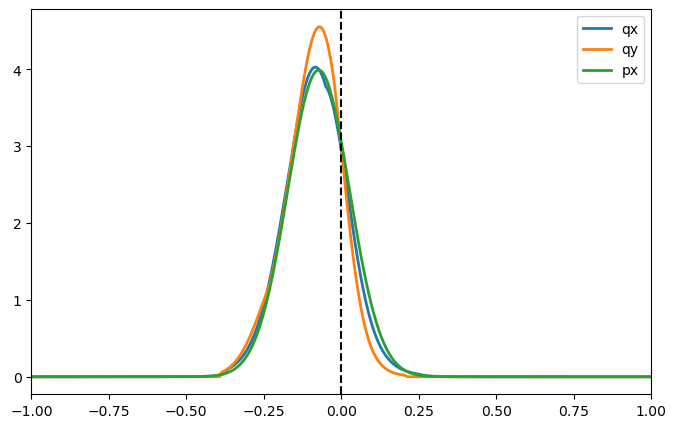

In [23]:

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

torch.manual_seed(42)

# define the prior over theta
prior = torch.distributions.Normal(
    loc=torch.tensor([0.0]), scale=torch.tensor([5.0])
)

# define the model to work with
def gaussian(theta, sigma, summ_stats):
    zx = torch.distributions.Normal(loc=theta, scale=sigma).sample((100,))
    sx = {}
    sx['mean'] = zx.mean()
    sx['var'] = zx.var()
    sx['raw'] = zx[0]
    sx['mean_two_realisations'] = torch.distributions.Normal(loc=theta, scale=sigma).sample((2,)).mean()
    ss = []
    for st in summ_stats:
        ss.append(sx[st])
    
    return torch.tensor(ss)

# choose which summary statistics to consider
ss = ['mean', 'var']

# fix the standard deviations of the zx
sigma_x = 1.0

# make sure that prior and model are in SBI format
simulator, prior = prepare_for_sbi(
    partial(gaussian, sigma=sigma_x, summ_stats=ss),
    prior)

# instantiate the density estimator to use
density_estimator_build_fun = posterior_nn(
    model="nsf",
    hidden_features=40,
    num_transforms=5,
    num_bins=10,
    num_blocks=2
)

# instantiate an inference object
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)

# generate the training dataset with simulations
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=50_000)
# store the simulations in the inference object
inference = inference.append_simulations(theta, x)

# train the neural spline flow on the simulated data
density_estimator = inference.train(training_batch_size=256,
                                    stop_after_epochs=5,
                                    max_num_epochs=50,
                                    learning_rate=5e-4,
                                    validation_fraction=0.10)

# build the posterior estimator object
posterior = inference.build_posterior(density_estimator)

# choose the ground truth value of the input parameter
mu = torch.tensor([0.0]).view(1,-1)

# generate observations
x = gaussian(theta=mu, sigma=sigma_x, summ_stats=ss)

sigma_y = np.sqrt(2)
y = gaussian(theta=mu, sigma=sigma_y, summ_stats=ss)

# generate samples via rejection sampling
tt = torch.linspace(-2, 2, 1000).view(-1, 1)
qx = torch.exp(posterior.log_prob(tt, x=x))
qy = torch.exp(posterior.log_prob(tt, x=y))

tt = np.linspace(-2, +2, 1000)
px = np.exp(-50*(tt - x[0].item())**2) * np.exp(-tt**2/50)
dt = tt[1] - tt[0]
Z = np.sum(px * dt)
px = px / Z

fig, ax = plt.subplots(figsize=(8, 5))
bins = torch.linspace(-2, +2, 100)
dx = bins[1] - bins[0]
ax.plot(tt, qx, lw=2.0, c='C0', label='qx')
ax.plot(tt, qy, lw=2.0, c='C1', label='qy')
ax.plot(tt, px, lw=2.0, c='C2', label='px')
ax.axvline(x=mu.item(), ls='--', c='k')
ax.set_xlim([-1, +1])
ax.legend()
fig.show()

In [24]:
import zuko
import lampe.inference
import lampe.utils
from tqdm.notebook import tqdm_notebook as tqdm
from lampe.utils import GDStep

from itertools import islice
from lampe.data import JointLoader

In [93]:
def generate_data(theta0,sigma_y_2=1):
    z = torch.distributions.Normal(theta0,1).sample((100,))
    mean = z.mean().unsqueeze_(0)
    var = z.var().unsqueeze_(0)
    z0, z1 = z[0], z[1]
    mean_two_z = torch.mean(torch.stack([z0, z1]))
    res = {}
    res["mean"] = {}
    res["mean"]["x"] = mean
    res["mean_two_z"] = {}
    res["mean_two_z"]["x"] = mean_two_z.unsqueeze_(0)
    res["mean_and_var"] = {}
    res["mean_and_var"]["x"] = torch.stack([mean,var]).squeeze_()
    res["two_z"] = {}
    res["two_z"]["x"] = torch.stack([z0,z1]).squeeze_()
    res["raw_z"] = {}
    res["raw_z"]["x"] = z0
    res["var"] = {}
    res["var"]["x"] = var
    for key in res.keys():
        epsilon = torch.distributions.Normal(torch.zeros_like(res[key]["x"]),np.sqrt(sigma_y_2)).sample()
        res[key]["eps"] = epsilon
    return res

In [26]:
M = 20_000 #TODO A changer + tard

## Observing the mean $ x = \frac{1}{N} \sum_{i=1}^{N}{z_i}$

In [27]:


def build_nsf(features, context):
    """Callable to instanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)

def train_flow(flow, loss, theta, x, theta_test, x_test):
    
    optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
    data = lampe.data.JointDataset(theta, x)
    loader = lampe.data.DataLoader(data, 256)
    
    with torch.no_grad():
        min_loss = loss(theta_test,x_test)
    min_loss_list = [min_loss]
    
    nsf.train()

    with tqdm(range(50), unit='epoch', leave=False, desc="Training NPE") as tq:
        for epoch in tq:
            flow.train()
            for theta_batch, x_batch in loader:
                losses = loss(theta_batch, x_batch)
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
            
            
            #Checking for early stopping
            with torch.no_grad():
                loss_test = loss(theta_test, x_test)
                min_loss_list.append(loss_test)
                if len(min_loss_list) - np.argmin(min_loss_list) > 5: #No improvement in loss(test) for the last 5 iterations
                    #Early stop  
                    tq.container.close()
                    break
            tq.set_postfix(loss=loss_test.item())
    flow.eval()
    return flow

nsf = lampe.inference.NPE(theta_dim = 1, x_dim=1, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
theta_test = prior.sample((M//10, ))
x = torch.stack([generate_data(theta_i)["mean"]["x"] for theta_i in theta])
x_test = torch.stack([generate_data(theta_i)["mean"]["x"] for theta_i in theta_test])
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 18


In [28]:
x_star = generate_data(theta_true,1)["mean"]["x"] #Suppose we observe one x=mean(sample) where sample~N(θ|1)
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))

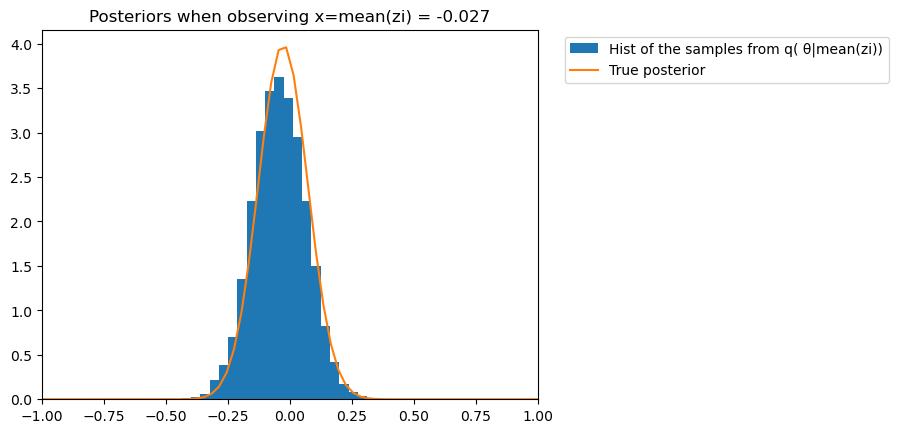

In [29]:
plt.hist(samples.numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(zi))")
true_post_summaries = [posterior_x_N(theta, x_star.numpy()) for theta in theta_grid]
plt.plot(theta_grid, true_post_summaries, label="True posterior")
plt.xlim(left=-1,right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(zi) = {x_star.item():.3f}")
plt.show()

## When taking the observed mean and variance as summaries : $$x = (x_1, x_2),\\ x_1=\frac{1}{N}\sum_{i=1}^{N}{zi} \\ x_2 = \frac{1}{N}\sum_{i=1}^N{\left( z_i-x_1 \right) }^2$$

In [30]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
x = torch.stack([generate_data(theta_i)["mean_and_var"]["x"] for theta_i in theta])
theta_test = prior.sample((M//10, ))
x_test = torch.stack([generate_data(theta_i)["mean_and_var"]["x"] for theta_i in theta_test])
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 37


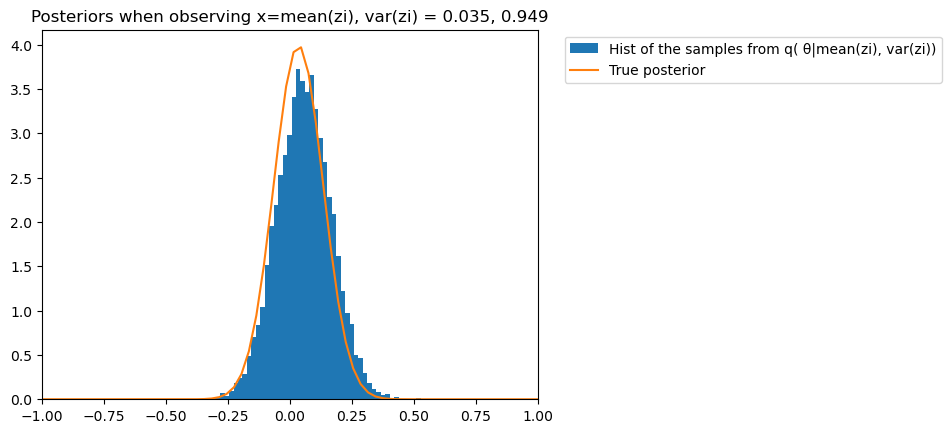

In [31]:
x_star = generate_data(theta_true, 1)["mean_and_var"]["x"]
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))
    
plt.hist(samples.numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(zi), var(zi))")
eval_post_summaries = [posterior_summaries(theta, x_star[0].item(), x_star[1].item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-1,right=1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(zi), var(zi) = {x_star[0].item():.3f}, {x_star[1].item():.3f}")
plt.show()

## Observing the mean $ x = \frac{1}{2} \left( z_1 + z_2 \right)$

In [32]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=1, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
x = torch.stack([generate_data(theta_i)["mean_two_z"]["x"] for theta_i in theta])
theta_test = prior.sample((M//10, ))
x_test = torch.stack([generate_data(theta_i)["mean_two_z"]["x"] for theta_i in theta_test])
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)
x_star = generate_data(theta_true,1)["mean_two_z"]["x"]
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 34


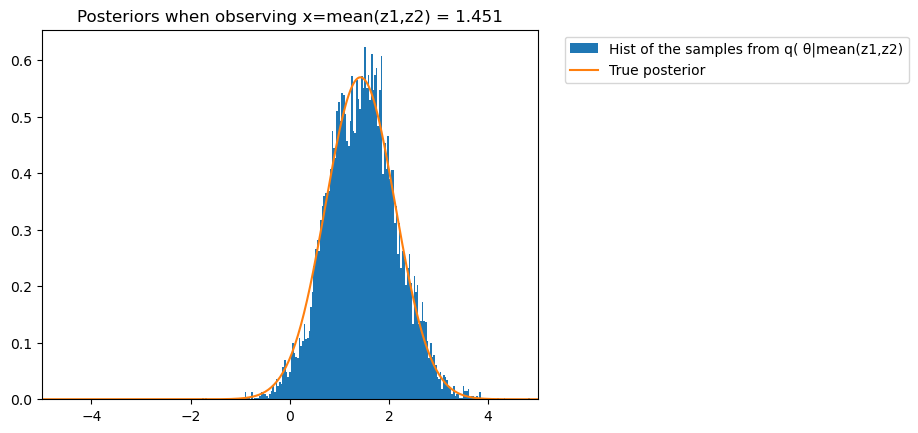

In [33]:
plt.hist(samples.numpy(), density=True, bins=200, label="Hist of the samples from q( θ|mean(z1,z2)")
eval_post_summaries = [posterior_x(theta, x_star.item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing x=mean(z1,z2) = {x_star.item():.3f}")
plt.show()

## Observing two realisations $ z_1,z_2$

In [34]:
a = generate_data(theta_true)["raw_z"]["x"]
a.shape

torch.Size([1])

In [35]:
nsf = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)
loss = lampe.inference.NPELoss(nsf)
theta = prior.sample((M, ))
x = torch.stack([generate_data(theta_i)["two_z"]["x"] for theta_i in theta])
theta_test = prior.sample((M//10, ))
x_test = torch.stack([generate_data(theta_i)["two_z"]["x"] for theta_i in theta_test])
nsf = train_flow(nsf,loss,theta,x, theta_test, x_test)

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 23


In [36]:
x_star = generate_data(theta_true,1)["two_z"]["x"]
nsf.eval()
with torch.no_grad():
    samples = nsf.sample(x_star, (10_000,))

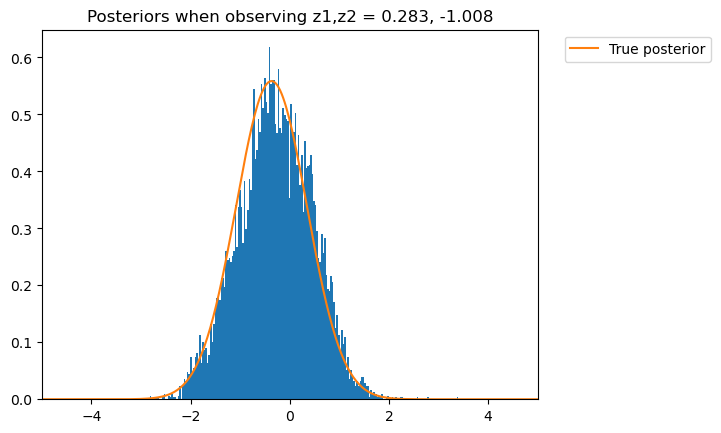

In [37]:
plt.hist(samples.numpy(),density=True, bins=200)
eval_post_summaries = [posterior_z(theta, x_star[0].item(), x_star[1].item()) for theta in theta_grid]
plt.plot(theta_grid, eval_post_summaries, label="True posterior")
plt.xlim(left=-5,right=5)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(f"Posteriors when observing z1,z2 = {x_star[0].item():.3f}, {x_star[1].item():.3f}")
plt.show()

In [38]:
#TODO Mettre avec obs=var

In [47]:
def get_posterior(summaries,theta_star, sigma_y_2=1):
    shape_x = lambda x: 2 if x=="mean_and_var" or x=="two_z" else 1
    flow = lampe.inference.NPE(theta_dim= 1, x_dim=shape_x(summaries) , build=build_nsf)
    loss = lampe.inference.NPELoss(flow)
    theta = prior.sample((M, ))
    x =  torch.stack([generate_data(theta_i)[summaries]["x"] for theta_i in theta])
    theta_test = prior.sample((M//10, ))
    x_test = torch.stack([generate_data(theta_i)[summaries]["x"] for theta_i in theta_test])

    
    flow = train_flow(flow, loss, theta, x, theta_test, x_test)
    
    #Getting new observed data
    data_star = generate_data(theta_star,sigma_y_2)
    x_star = data_star[summaries]["x"]
    flow.eval()
    #Getting samples from the trained flow
    with torch.no_grad():
        samples = flow.sample(x_star, (10_000,))

    #Getting the true posterior
    true_post = get_true_post(summaries, x_star)
    
    #
    y_star = data_star[summaries]["eps"] + x_star
    with torch.no_grad():
        samples_y = flow.sample(y_star, (10_000, ))
    
    return true_post, samples, samples_y
    


In [92]:
2%3

2

In [102]:
def prepare_ax_posteriors(sigma_2):
    plt.close()
    sigma_y = (sigma_2-1)
    summaries = ["two_z", "mean_two_z", "mean", "mean_and_var","var"]
    fig, ax = plt.subplots(3, 2, figsize=(10,10))
    i=0
    with tqdm(summaries, unit='summary statistic', leave=False,desc="Summaries") as tq:
        for summary in tq:
            tq.set_postfix(summary=summary)
            true_post, samples, samples_y = get_posterior(summary, theta_true, sigma_y=sigma_y)
            row = i // 2  
            col = i % 2 
            
            hist = ax[row, col].hist(samples.numpy(), density=True, bins=200, label="SBI Posterior q(θ|x)", alpha=0.55)
            ax[row, col].plot(theta_grid, true_post, label="True posterior p(θ|x)")
            ax[row, col].hist(samples_y.numpy(), density=True, bins=200, label="SBI Posterior q(θ|y)", alpha=0.5)
            ax[row, col].axvline(x=theta_true, ls='--', c='k')
        # ax[row, col].set_xlim(-1, 1)
            #if "mean_two_realisations" in summary:
            #   ax[row, col].set_xlim(-3,3)
            ax[row, col].set_title(f"using {summary} as summary")  
            lower_quantile = np.percentile(hist[1], 5)
            upper_quantile = np.percentile(hist[1], 95)
            ax[row, col].set_xlim(lower_quantile, upper_quantile)
            #ax[row, col].set_xlim(-3,3)
            ax[row, col].legend()
            i += 1
    fig.suptitle(f"Posteriors with sigma² = {sigma_2}")
    return fig


In [103]:
figs = {}
sigmas_2 = [1,2,3,4]
with tqdm(sigmas_2, unit='Sigma', desc="Sigmas") as tq:
    for sigma_2 in tq:
        tq.set_postfix({"sigma²":sigma_2})
        figs[sigma_2] = prepare_ax_posteriors(sigma_2)
        plt.close()

Sigmas:   0%|          | 0/4 [00:00<?, ?Sigma/s]

Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 8


c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\matplotlib\cbook\__init__.py:1335: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 11


c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\mmmat\anaconda3\envs\sbi_env1\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 10


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 19


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 17


Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 23


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 15


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 26


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 15


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 20


Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 10


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 7


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 10


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 20


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 10


Summaries:   0%|          | 0/5 [00:00<?, ?summary statistic/s]

Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 12


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 21


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 21


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 13


Training NPE:   0%|          | 0/50 [00:00<?, ?epoch/s]

 Early stop at epoch 14


In [104]:
@widgets.interact(sigma_2=(1,4,1))
def plot_posteriors_widget(sigma_2=1):
    plt.close()
    return figs[sigma_2]


interactive(children=(IntSlider(value=1, description='sigma_2', max=4, min=1), Output()), _dom_classes=('widge…

In [ ]:
todo : 
    graph selons les sigma? (ps changer xlim, prendre genre le min? ou un percentil?)
    voir en scalant les data si on perd

SyntaxError: invalid syntax (1814866518.py, line 1)